In [296]:
import numpy as np
import matplotlib.pyplot as plt

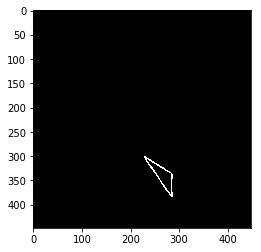

In [297]:

# 路径图像（坐标放到图片里看需要放大2倍）
path_image=np.load("TSP_Unet_out_1/lr=0.0003_1/out/1.npy")
plt.imshow(path_image,cmap=plt.cm.gray)
plt.show()

In [298]:
NUM_CITY = len(city_site)
city_site = np.load("partial_npy/1.npy")
city_site = city_site * 2
# 结合实际坐标来看，神经网络的输出坐标变小了，可能是png转npy代码的问题
for i in range(len(city_site)): # 坐标需要换回先y后x
    city_site[i][0], city_site[i][1] = city_site[i][1], city_site[i][0]
print(city_site)

[[320 220]
 [366 296]
 [354 242]
 [430 296]]


In [299]:
# 函数：生成单个线条是最优路径的概率值
def line(startx,starty,endx,endy,path_image):
    # startx 和 starty 是线条出发点的横纵坐标
    # endx 和 endy 是线条到达点的横纵坐标
    # path_image 是路径图像
    n1=abs(endx-startx)
    n2=abs(endy-starty)
    n=max(n1,n2) # 路径像素点总数
    coincide=0 #重合次数
    if n==n1:
        if startx >= endx:
                for x in range(endx,startx):
                        y=int((x-startx)*(endy-starty)/(endx-startx))+starty
                        # 注：额外判断线条上下一个像素点，可以增加准确率
                        if path_image[x,y]==1 or path_image[x,y+1]==1 or path_image[x,y-1]==1:
                            coincide=coincide+1
        else:
                for x in range(startx,endx):
                        y=int((x-startx)*(endy-starty)/(endx-startx))+starty
                        if path_image[x,y]==1 or path_image[x,y+1]==1 or path_image[x,y-1]==1:
                            coincide=coincide+1
    if n==n2 and n!=n1:
        if starty >= endy:
                for y in range(endy,starty):
                        x=int((y-starty)*(endx-startx)/(endy-starty))+startx
                        if path_image[x,y]==1 or path_image[x-1,y]==1 or path_image[x+1,y]==1:
                            coincide=coincide+1
        else:
                for y in range(starty,endy):
                        x=int((y-starty)*(endx-startx)/(endy-starty))+startx
                        if path_image[x,y]==1 or path_image[x-1,y]==1 or path_image[x+1,y]==1:
                            coincide=coincide+1
        
    return coincide/n # 返回 重合次数/路径像素点总数

In [300]:
# 函数测试： 第一个城市与第二个城市之间连线的概率值
line(206,192,320,220,path_image)

0.0

In [301]:
# 函数 生成所有城市之间连线的概率值
def belief_value(city_site,path_image):
    # 输入城市坐标 与 路径图像
    A=np.zeros([NUM_CITY,NUM_CITY]) # 邻接矩阵
    # 对于A逐行逐列生成连线概率值,计算上三角矩阵
    for row in range(NUM_CITY-1):
        for col in range(row+1,NUM_CITY):
            A[row,col]=line(city_site[row,0],city_site[row,1],city_site[col,0],city_site[col,1],path_image)
    # 下三角矩阵采用上三角矩阵转置生成
    for row in range(NUM_CITY):
        for col in range(row,NUM_CITY):
            A[col,row]=A[row,col]
    return A

In [302]:
# 测试函数
A=belief_value(city_site,path_image)
# 出现小数点的原因是城市坐标位置的像素被记入了路径的概率值
# 如果输出图像中区分城市和路径可以避免这个问题
print(A)

[[0.         0.14473684 0.         0.        ]
 [0.14473684 0.         0.16666667 0.        ]
 [0.         0.16666667 0.         0.        ]
 [0.         0.         0.         0.        ]]


In [303]:
def distance(p1, p2):
    p3 = p2 - p1
    print(p3)
    dis = np.linalg.norm(p2 - p1)
    return dis

In [304]:
print(distance(city_site[0], city_site[1]))

[46 76]
88.83692925805124


In [305]:
# 生成城市搜索次序表
City_order=np.arange(NUM_CITY)
# 以A中第0行出发，找出下一个城市
Next_City=0
Total = 0.0
print("出 发 城 市:",city_site[Next_City])
for search_city in range(1,NUM_CITY):
    Curr_City = Next_City
    # 将已经经过的城市从搜索次序表中剔除
    City_order=City_order[np.where(City_order!=Next_City)]
    # 在未经过的城市之中搜索
    biggest_prob=0
    for i in range(NUM_CITY):
        if i in City_order and A[Next_City,i]>biggest_prob:
            biggest_prob=A[Next_City,i]
            Next_City=i
    Total += distance(city_site[Curr_City], city_site[Next_City])
    print("第",search_city,"个城市:",end=" ")
    print(city_site[Next_City])
Total += distance(city_site[0], city_site[Next_City])  # 回到出发城市
print("返 回 城 市:",city_site[0])
print(Total)

出 发 城 市: [320 220]
[34 22]
第 1 个城市: [354 242]
[12 54]
第 2 个城市: [366 296]
[0 0]
第 3 个城市: [366 296]
[46 76]
返 回 城 市: [320 220]
184.65110946444173
